In [2]:
import sys
sys.path.append('../../src/')
from vi_hrg import *
from utils import *
from torch import autograd
torch.manual_seed(82)

In [3]:
def noise_r(x, R, rel_var=0.1, epsilon=1e-4):
    rs = torch.distributions.normal.Normal(x, R*rel_var).sample() 
    return torch.clamp(rs, min=0+epsilon, max=R-epsilon)

In [4]:
def noise_phi(x, rel_var=0.1):
    phis = torch.distributions.normal.Normal(x, 2*np.pi*rel_var).sample()
    return phis % (2*np.pi)

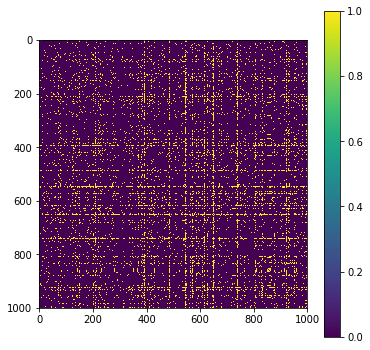

In [161]:
N = 1000
R = 8.0
alpha = 0.7
T = 0.1

G = HRG(R=R, alpha=alpha, T=T)
r, theta, A = G.generate(N)
G.show()
#G.plot()

In [162]:
def hrg_likelihood_T0(A, r, phi_polar, R, T, alpha, debug=False):
    eps = -1e+10
    n = len(r)
    edges = torch.where(A>0, 
                            torch.ones(A.size()), 
                            torch.zeros(A.size()))
    l1e_a_ri = log1mexp(alpha*r*2)
    #print(l1e_a_ri.sum())
    l1e_a_R = log1mexp(alpha*R)
   # print(l1e_a_R)
    a_R_ri = alpha * (r-R)
    #print(a_R_ri.sum())
    r_matrix = r.expand(n,n)
    phi_matrix = phi_polar.expand(n,n)
    hd = hyperdist(r_matrix, r_matrix.t(), phi_matrix, phi_matrix.t())
    if T==0:
        threshold = torch.where(hd<R,
                                torch.zeros(hd.size()),
                                torch.ones(hd.size())*eps)
        threshold_ = torch.where(hd<R,
                                torch.ones(hd.size())*eps,
                                torch.zeros(hd.size()))
        
        #threshold = torch.clamp(((cd*2).log()<R).float(), min=1e-2)
        #print(threshold)
        lp = torch.where(edges==1,
                        threshold,
                        threshold_)
        #lp = edges*(threshold.log()) + (1-edges)*(1-threshold).log()
    else:
        l1pe = (hd-R)/(2*T)
        lp = edges*(-log1pexp(l1pe)) + (1-edges)*(log1pexp_(l1pe))
    lp = lp.triu(diagonal=1)
    #print(lp)
    if debug: print('Prob edges >>', lp.sum().item())
    if debug: print('a_R_ri  >>', (a_R_ri+l1e_a_ri).sum().item())
    if debug: print('Alpha       >>', alpha.log().item())
    if debug: print('l1e_a_R     >>', 2*l1e_a_R.item())
    out = lp.sum() + (a_R_ri+l1e_a_ri).sum() + alpha.log() \
        - torch.tensor(np.pi*2).log() - 2*l1e_a_R
    return lp

In [163]:
# Original values, T=0
tv = hrg_likelihood_T0(A, r, theta, torch.tensor(R), torch.tensor(T), torch.tensor(alpha), 
                       debug=False).sum().item()
tv

-12292.488320811473

In [164]:
Rs = torch.arange(7.5, 8.5, 0.1)
Ts = torch.arange(0.0, 0.2, 0.0005)
alphas = torch.arange(.02, 1.02, .02)

In [165]:
lh_a = []
for Ri in Rs:
    lh_ =[]
    for t in Ts:
        lh_.append(hrg_likelihood_T0(A, r, theta, torch.tensor(Ri), t, torch.tensor(0.75), 
                       debug=False).sum().item())
    lh_a.append(lh_)

 /home/mo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor). 


In [166]:
lh_a = np.array(lh_a)
lh_clampd = torch.clamp(torch.tensor(lh_a), min=-20000)

In [167]:
#np.save('paramsearchTa_n5000_R8_T01_a07.npy', lh_a)

In [168]:
#levels = [-1960, -1980, -2000, -2500, -3000, -3500, -4000, -5000, -6000, -10000]

In [169]:
max_index = np.unravel_index(lh_clampd.argmax(), lh_clampd.shape)
R_max = Rs[max_index[0]].item()
T_max = Ts[max_index[1]].item()
R_max, T_max

(8.0, 0.09950000047683716)

In [170]:
max_index

(5, 199)

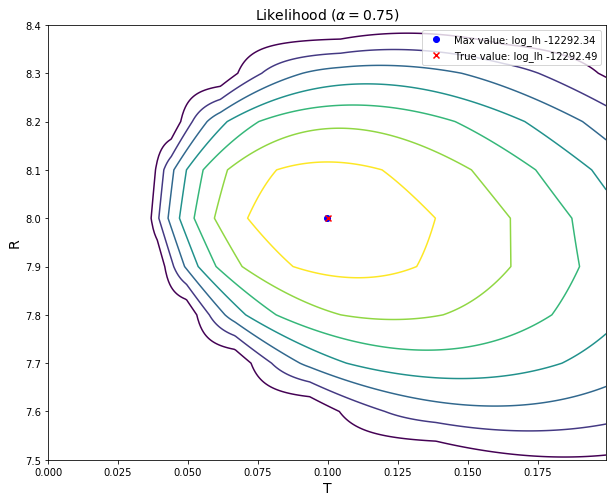

In [171]:
plt.figure(figsize=(10,8))
im = plt.contour(Ts.numpy(), Rs.numpy(), lh_clampd, alpha=1.)
plt.scatter(T_max, R_max, color='blue', marker='o', label=str('Max value: log_lh %.2f' % lh_clampd.max().item()))
plt.scatter(T, R, color='red', marker='x', label=str('True value: log_lh %.2f' % tv))
plt.title(r'Likelihood ($\alpha=0.75$)', fontsize=14)
plt.xlabel('T', fontsize=14)
plt.ylabel(r'R', fontsize=14)
#plt.colorbar(im)
plt.legend()
plt.show()

In [12]:
lh_clampd.max(), lh_clampd[max_index]

(tensor(-350000., dtype=torch.float64), tensor(-350000., dtype=torch.float64))